In [13]:
import pandas as pd
df = pd.read_excel('customer_churn_data.xlsx')
df = df.dropna(subset=['Category'])

In [16]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elsaj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elsaj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elsaj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\elsaj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Preprocessing the data

In [17]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [18]:
categories = df['Category'].unique()
preprocessed_data = {}
for category in categories:
    subset = df[df['Category'] == category]
    preprocessed_data[category] = subset['Customer Feedback'].apply(preprocess_text)

Perform sentiment analysis

In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\elsaj\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [20]:
sid = SentimentIntensityAnalyzer()
def get_sentiment_vader(text):
    scores = sid.polarity_scores(text)
    return scores['compound']

In [28]:
sentiment_results = {}
for category, feedbacks in preprocessed_data.items():
    sentiment_scores = feedbacks.apply(lambda x: get_sentiment_vader(x))
    sentiment_results[category] = sentiment_scores  # Average sentiment score per category

In [41]:
sentiment_results

{'Credit Card': 0      0.3818
 34     0.1779
 43     0.8126
 56     0.8519
 60     0.3818
 66     0.6705
 71     0.6369
 109    0.1779
 139    0.8750
 167    0.6705
 177    0.1779
 215   -0.0258
 242    0.6249
 243    0.3818
 250    0.3818
 266    0.3818
 290    0.5719
 298    0.8176
 317    0.7430
 321    0.5994
 328    0.6249
 343    0.8176
 376    0.1779
 388    0.8750
 429    0.6705
 430    0.8176
 451    0.8481
 474    0.8126
 525    0.3818
 539    0.6705
 542    0.3818
 545    0.1779
 555    0.8176
 563    0.7430
 583    0.8750
 684    0.6705
 692    0.3818
 704    0.8750
 705    0.6249
 725    0.8750
 754    0.3818
 759    0.1779
 789    0.3818
 790    0.8176
 798    0.8176
 831    0.3818
 864    0.3818
 868    0.3818
 871    0.8519
 882    0.8176
 886    0.8126
 897    0.3818
 898    0.8126
 910    0.3818
 962    0.2960
 967    0.2960
 990    0.1280
 Name: Customer Feedback, dtype: float64,
 'Current Account': 1      0.0000
 10     0.0000
 12     0.0000
 24    -0.4019
 26     0

Keyword Extraction

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
keyword_results = {}
n_keywords=20
for category, feedbacks in preprocessed_data.items():
        # Convert Series to list for TF-IDF processing
    feedback_list = feedbacks.tolist()
        
        # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=n_keywords, stop_words='english')
        
        # Fit and transform the feedback data
    X = vectorizer.fit_transform(feedback_list)
        
        # Get feature names (keywords)
    keywords = vectorizer.get_feature_names_out()
        
    keyword_results[category] = keywords

In [38]:
print(keyword_results['ATM Service'], keyword_results['Debit Card'])

['atm' 'cash' 'charge' 'fee' 'functional' 'high' 'house' 'limit' 'low'
 'near' 'network' 'office' 'reliable' 'service' 'unreliable' 'withdrawal'] ['accepted' 'activation' 'atm' 'card' 'complicated' 'confusing' 'debit'
 'delayed' 'delivered' 'delivery' 'need' 'pin' 'place' 'process' 'quickly'
 'replacement' 'reset' 'slow' 'transaction' 'working']


Visualizing sentiment distribution

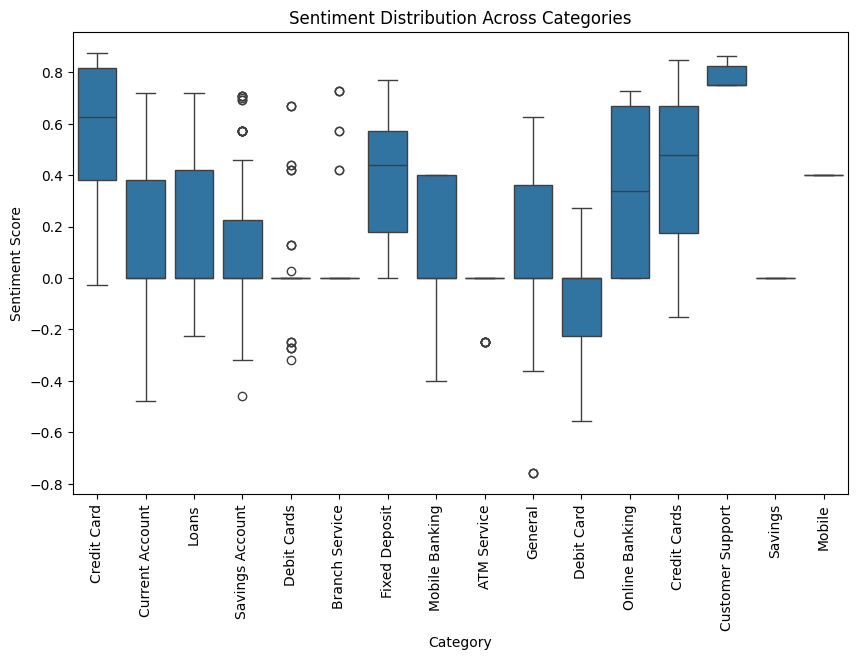

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
def create_sentiment_dataframe(sentiment_by_category):
    data = []
    for category, sentiments in sentiment_by_category.items():
        for sentiment in sentiments:
            data.append({'Category': category, 'Sentiment': sentiment})
    return pd.DataFrame(data)
df_sentiment = create_sentiment_dataframe(sentiment_results)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Sentiment', data=df_sentiment)
plt.title('Sentiment Distribution Across Categories')
plt.ylabel('Sentiment Score')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.show()


Visualizing key themes across categories

In [39]:
from wordcloud import WordCloud
def plot_wordcloud(themes_by_category, selected_categories):
    for category in selected_categories:
        if category in themes_by_category:
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(themes_by_category[category]))
            plt.figure(figsize=(10, 6))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f'Key Themes in {category}')
            plt.axis('off')
            plt.show()
        else:
            print(f"Category '{category}' not found in themes_by_category.")


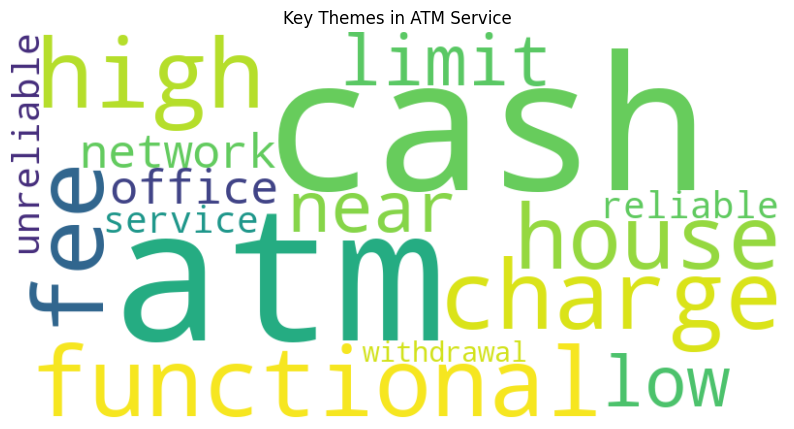

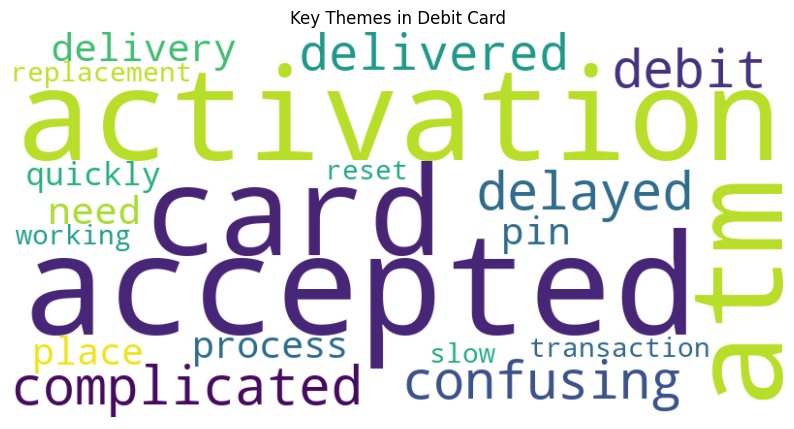

In [40]:
selected_categories = ['ATM Service', 'Debit Card']
plot_wordcloud(keyword_results, selected_categories)